In [ ]:
%%HTML
<!-- Make fonts readable at 1024x768 -->
<style>
.rendered_html { font-size:0.7em; }
</style>

In [3]:
# Imports and matplotlib configuration
import numpy as np
import scipy.signal
from scipy import fftpack
%matplotlib notebook
import matplotlib.pylab as plt
from matplotlib import animation, rcParams, patches
from ipywidgets import interact, FloatSlider, IntSlider, SelectionSlider, Layout, Button, Output, Box
from IPython.display import display, Audio, HTML
import soundfile as sf

# Default options for matplotlib plots
rcParams['figure.dpi'] = 80
rcParams['font.size'] = 14
rcParams['axes.grid'] = True
rcParams['lines.linewidth'] = 2.0
rcParams['legend.framealpha'] = 0.5
rcParams['legend.fontsize'] = 'medium'
rcParams['figure.titlesize'] = 'medium'
rcParams['figure.autolayout'] = True
# rcParams['animation.html'] = 'html5'
slider_layout = Layout(width='500px', height='20px')
slider_style = {'description_width': 'initial'}
from functools import partial
FloatSlider_nice = partial(FloatSlider, style=slider_style, layout=slider_layout, continuous_update=False)
IntSlider_nice = partial(IntSlider, style=slider_style, layout=slider_layout, continuous_update=False)
SelectionSlider_nice = partial(SelectionSlider, style=slider_style, layout=slider_layout, continuous_update=False)

# Optional: Set options for slide theme and transition
from traitlets.config.manager import BaseJSONConfigManager
path = "/home/phuijse/.jupyter/nbconfig/"
cm = BaseJSONConfigManager(config_dir=path)
cm.update('livereveal', {
    'theme': 'simple',
    'transition': 'fast',
    'start_slideshow_at': 'selected',
    'width': 1024,
    'height': 768,
    'scroll': True,
    'center': False
});

def clean_4_audio(y):
    if np.amax(np.absolute(y)) > 1.:
        return y/np.amax(np.absolute(y))
    else:
        return np.concatenate((y, [1, -1]))

### Universidad Austral de Chile 

## INFO183: Análisis de sistemas lineales

# Unidad 3: Sistemas para el procesamiento de señales

### Dr. Pablo Huijse, phuijse at inf dot uach dot cl 

### <a href="https://github.com/phuijse/UACH-INFO183"> github.com/phuijse/UACH-INFO183 </a>


***
<a id="index"></a>

# Contenidos de la unidad

***

1. [Definición de sistema](#section1)
1. [Sistemas LTI y filtros](#section2)

***
[Volver al índice](#index)
<a id="section1"></a>

# Definición de sistema

***

- *Análisis de señales:* El estudio de las señales y sus propiedades en el dominio del tiempo y frecuencia
- *Procesamiento de señales:* El diseño de **sistemas** que procesan **señales de entrada** y producen **señales de salida**
    - Adicionalmente, un sistema puede tener parámetros (entradas númericas o booleanas)
    - Adicionalmente, un sistema puede tener retornos (salidas númericas o booleanas)
    - Sistema sin señal de entrada: Oscilador
    - Sistema sin señal de salida: Detector/clasificador de señal
    - Existen sistemas analógicos (continuos) y digitales (discretos), nos enfocaremos en los últimos
    
   
<center><img src="img/system.png"></center>

- Usaremos $x[n]$ para denotar la señal (discreta) de entrada y $X[k]$ su espectro
- Usaremos $y[n]$ para denotar la señal (discreta) de salida e $Y[k]$ su espectro
 


### Ejemplos

1. Un sistema para reducir el ruido de una EEG

<center><img src="img/system-denoise-eeg.png"></center>

1. Un sistema para mejorar (sharpen) una imagen fuera de foco

<center><img src="img/system-sharpen.jpg"></center>

1. Un sistema para eliminar el eco de un audio

<center><img src="img/system-echo.png"></center>


***

# Sistemas  sin memoria

Los sistemas sin memoria son de forma

$$
y[n] = f(x[n]),
$$

es decir la salida del sistema en un instante dado depende solo de la entrada en ese instante

### Ejemplos


- Sistema amplificador ideal 
$$
y[n] = A x[n], 
$$
donde $A>0$ se llama *ganancia*
    - provoca atenuación de la entrada si $0<A<1$
    - es un sistema identidad si $A=1$

- Sistema con corrupción cuadrática
$$
y_n = x_n + \epsilon x_n^2
$$

- Sistema saturador (clamp)
$$
y_n = \begin{cases} B &x_n > B \\x_n & x_n \in [-B, B]\\ -B & x_n < -B\end{cases}
$$
- Sistema rectificador
$$
y_n = | x_n |
$$

In [ ]:
plt.close('all'); fig, ax = plt.subplots(figsize=(7, 4))
Fs = 22050; n = np.arange(0, 2, step=1.0/Fs)
x = 0.2*np.sin(2.0*np.pi*200*n); 
y = x #+ 2*x**2
ax.plot(n, x, label='input'); ax.plot(n, y, label='output'); 
ax.set_xlim([0, 0.1]); plt.legend()
Audio(clean_4_audio(y), rate=Fs)

***

# Sistema Lineal

Propiedades de los sistemas lineales

- **Homogeneidad:** Un cambio en la amplitud de la entrada produce un cambio equivalente en la salida

$$
f(cx[n]) = c f(x[n]) = c y[n]
$$

- **Aditividad:** Señales que se suman en la entrada producen señales que se suman en la salida

$$
f(x_1[n] + x_2[n]) = f(x_1[n]) + f(x_2[n]) = y_1[n] + y_2[n]
$$

    - Las señales pasan por el sistema sin interactuar entre ellas
- Si no se cumple alguna de estas propiedades el sistema es **no lineal**
- ¿Son los sistemas anteriores lineales?



### Otras propiedades de los sistemas lineales


- Una cascada de sistemas lineales forman un sistema lineal equivalente
    - **Conmutatividad:** El orden de los sistemas en la cascada no es relevante
<img src="img/system-conmu.png" width="400px">

- **Principio de superposición**: 
    - Considere una método de descomposición de funciones (Fourier, Taylor, PCA)
    - Si descomponemos una señal en $M$ componentes: $x[n] = x_1[n] + x_2[n] + \ldots +  x_M[n]$
    - Y aplicamos un **sistema lineal** a cada componente $y_j[n] = f(x_j[n])$
    - Podemos recuperar la salida total usando **aditividad** como $y_1[n] + y_2[n] + \ldots +  y_M[n] = y[n]$

<img src="img/system-superpos.png" width="400px">
    


***

# Sistemas con memoria

Un sistema con memoria es aquel cuya salida puede depender de 
- la entrada actual
- las entradas anteriores
- las salidas anteriores

$$
\begin{align}
y[n] = f(x[n], &x[n-1], x[n-2], \ldots, x[0], \\ \nonumber
&y[n-1], y[n-2], \ldots, y[0]) \nonumber
\end{align}
$$

esto también se conoce como **sistema causal**

Un **sistema no-causal** usa entradas futuras ($x[n+1]$, $x[n+2]$, ...) y por ende solo se puede implementar de forma offline (una vez que sea ha observado toda la señal)

### Ejemplos de sistemas lineales con memoria simples

- Sistema con un retardo (delay)

$$
y[n] = x[n-m],
$$
    - depende solo de "una" entrada anterior
    - el valor de m define que tan "antigua" es la entrada pasada

- Sistema reverberador (eco)

$$
y[n] = x[n] + A x[n-m],
$$

    - depende de una entrada "pasada" y la entrada actual
    - la ganancia controla si el "eco" se atenua o amplifica

- El delay no afecta la amplitud de los componentes frecuenciales pero si su fase
- Más adelante veremos que este es un tipo de filtro conocido como pasa-todo (*all-pass*)

In [ ]:
plt.close('all'); fig, ax = plt.subplots(3, figsize=(6, 6))
n = np.arange(0, 400, step=1)
x = lambda m: np.sin(2.0*np.pi*0.05*(n-m)) 
f = fftpack.fftshift(fftpack.fftfreq(d=1, n=len(n)))

def update(m):
    m = m*0.5 # Para hacer la animación + fluida
    ax[0].cla(); ax[0].plot(n, x(m));
    X = fftpack.fftshift(fftpack.fft(x(m)))
    Xm = np.absolute(X); Xp = np.angle(X)
    # Espectro de magnitud:
    ax[1].cla(); ax[1].plot(f, Xm); 
    # Espectro de fase enmascarado con el espectro de magnitud
    ax[2].cla(); ax[2].plot(f, Xm*Xp/np.amax(Xm)); ax[2].set_ylim([-np.pi, np.pi])
    angle_delay = Xp[np.argmax(Xm)]
    ax[2].set_title("%0.4f [rad], %0.0f [deg]" % (angle_delay, 180*angle_delay/np.pi))

#interact(update, m=IntSlider_nice(min=0, max=20));
anim = animation.FuncAnimation(fig, update, frames=40, interval=100, blit=True)

$$
x[n] = A \sin(2 \pi k_0 (n-m)/N)
$$

$$
\begin{align}
X[k] &= A \sum_{n=0}^{N-1} \sin(2 \pi k_0 (n-m)/N) e^{-j2\pi \frac{nk}{N}} \\ \nonumber
& = \frac{A}{2j} e^{-j2\pi m/N} \sum_{n=0}^{N-1}  e^{-j2\pi \frac{n(k-k_0)}{N}} -  \frac{A}{2j} e^{j2\pi m/N} \sum_{n=0}^{N-1} e^{-j2\pi \frac{n(k+k_0)}{N}}
\end{align}
$$

In [ ]:
plt.close('all'); fig, ax = plt.subplots(figsize=(6, 3))
Fs=22050; n = np.arange(0, 4, step=1.0/Fs) 
x = lambda m: np.sin(2.0*np.pi*880*(n-m))*np.exp(-(n-m)**2/0.5**2)*np.heaviside(n-m, 0)
y = x(0)  #+ 0.5*x(1.)   + 0.25*x(2.) + 0.125*x(3.)
ax.plot(n, y);
Audio(clean_4_audio(y), rate=Fs)

- El eco en cambio si modifica el espectro de magnitud
- Notemos el efecto de interferencia constructiva y destructiva al modificar el retardo
- La señal retardada cancela la original cuando tiene la misma amplitud ($A=1$)

In [ ]:
plt.close('all'); fig, ax = plt.subplots(3, figsize=(6, 6))
n = np.arange(0, 400, step=1)
x = lambda m: np.sin(2.0*np.pi*0.05*(n-m)) 
f = fftpack.fftshift(fftpack.fftfreq(d=1, n=len(n)))
A = 0.5
def update(m):
    m = 0.5*m; y = x(0) + A*x(m)
    ax[0].cla(); ax[0].plot(n, x(0), n, A*x(m))
    ax[1].cla(); ax[1].plot(n, y); ax[1].set_ylim([-A-1.1, A+1.1])
    X = fftpack.fftshift(fftpack.fft(y))
    ax[2].cla(); ax[2].plot(f, np.absolute(X)); 
    ax[2].set_ylim([-20, (1+A)*len(n)/2 + 20])
#interact(update, m=IntSlider_nice(min=0, max=20), 
#         A=SelectionSlider_nice(options=[0.5, 1., 2.], value=1));
anim = animation.FuncAnimation(fig, update, frames=40, interval=100, blit=True)

Notemos que en el caso $A=1$

$$
\begin{align}
y[n] &= \sin(2\pi k_0 n) + \sin(2\pi k_0 (n-m)) \nonumber \\ 
&= 2 \cos(\pi k_0 m) \sin(2\pi k_0 (n-m/2))  \nonumber
\end{align}
$$

se anula si

$$
\begin{align}
\pi k_0 m & = \frac{\pi}{2} + \pi i, \quad i \in \mathbb{Z} \nonumber \\
m &= \frac{1 + 2i}{2 k_0}, \quad i \in \mathbb{Z} \nonumber
\end{align}
$$

In [ ]:
plt.close('all'); fig, ax = plt.subplots(figsize=(6, 3))
n = np.arange(0, 4, step=1.0/22050)
x = lambda m: np.sin(2.0*np.pi*880*(n-m))*np.exp(-(n-m)**2/0.5**2)*np.heaviside(n-m, 0)
y = x(0) + 1.*x(1./(2*880))
ax.plot(n, y);
Audio(clean_4_audio(y), rate=22050)

https://www.youtube.com/watch?v=IU8xeJlJ0mk

 ***

# Sistema FIR 

***

Generalizando el ejemplo de sistema lineal reverberante a más retardos llegamos a 

$$
\begin{align}
y[n] &= h[0] x[n] + h[1] x[n-1] + h[2] x[n-2] + \ldots + h[L] x[n-L] \nonumber \\
&= \sum_{j=0}^{L} h[j] x[n-j] \nonumber \\
&= (h* x)[n] \nonumber 
\end{align}
$$

que se puede modelar como una convolución discreta o en pseuco-código como un ciclo iterativo
```
   y[n] = 0
   for j in 0 to L
       y[n] = y[n] + h[j] x[n-j]
```
y se conoce como


- sistema FIR (finite impulse response)
- sistema MA (moving average)
- sistema todo-zeros 


y es de orden L (posee L+1 coeficientes)

- ¿Es este sistema lineal?
- ¿Que ocurre si entra al sistema un impulso unitario?

## Intepretación como media movil (MA)

- El sistema FIR es equivalente a una media movil ponderada (*weighted moving average*)
- Los coeficientes del sistema son los ponderadores 

Por ejemplo sea un sistema de 3 coeficientes unitarios
$$
\begin{align}
y[n] = (h*x)[n] &= \sum_{j=0}^{2} h[j] x[n-j] \nonumber \\
&= x[n] + x[n-1] + x[n-2] \nonumber
\end{align}
$$
donde cada salida se calcula a partir de 
$$
\overbrace{x[0], x[1], x[2]}^{y[2]} , x[3], x[4], \ldots
$$
$$
x[0], \overbrace{x[1], x[2] , x[3]}^{y[3]}, x[4], \ldots
$$
$$
x[0], x[1], \overbrace{x[2] , x[3], x[4]}^{y[4]}, \ldots
$$

En este caso para obtener el valor de $y[0]$ e $y[1]$ se deben establecer "condiciones de borde"

### Ejemplo: Eliminando ruido blanco aditivo

In [ ]:
plt.close('all'); fig, ax = plt.subplots(3, figsize=(6, 6))
np.random.seed(0); n = np.arange(0, 100, step=1)
C = 5*np.exp(-0.5*(n[:, np.newaxis] - n[:, np.newaxis].T)**2/10**2)
x_clean = np.random.multivariate_normal(np.zeros_like(n), C) 
ax[0].plot(n, x_clean)
x = x_clean + 2*np.random.randn(len(n))
ax[0].plot(n, x, 'k.')
ylims = ax[0].get_ylim()
# System:
L = 20; h = np.ones(shape=(L,))/L; 
# Acumulator
y = np.zeros_like(n, dtype=np.float)
def update(m):
    c = np.zeros_like(n, dtype=np.float); c[m:m+L] = h
    ax[1].cla(); ax[1].plot(n, c); 
    y[m] = np.sum(h*x[m:m+L])
    ax[2].cla(); ax[2].plot(n, y);  ax[2].set_ylim(ylims)
    ax[2].plot([m, m], [ylims[0], ylims[1]], 'r--', alpha=0.5)
#interact(update, L=SelectionSlider_nice(options=[1, 2, 3, 4, 5, 10, 15, 20]));
anim = animation.FuncAnimation(fig, update, frames=100-len(h), interval=40, blit=True)

En la práctica podemos usar [`scipy.signal.convolve`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve.html)

In [ ]:
plt.close('all'); fig, ax = plt.subplots(3, figsize=(6, 6))
ax[0].plot(n, x_clean); ax[0].plot(n, x, 'k.')
L = 10; 
h = np.ones(shape=(L,)); 
#h = scipy.signal.tukey(L)
#h = scipy.signal.hamming(L)
h = h/np.sum(h)
ax[1].plot(h)
ax[2].plot(scipy.signal.convolve(x, h, mode='same', method='auto')); 
ax[2].set_ylim(ylims);

### Ejemplo: Encontrando cambios en una señal

In [ ]:
plt.close('all'); fig, ax = plt.subplots(3, figsize=(6, 6))
n = np.arange(0, 100, step=1)
x = np.zeros_like(n, dtype=np.float)
x[20:] += 1.; x[40:] += 1.; x[80:] += 1.;
ax[0].plot(n, x)
# System:
h = np.array([-0.5, 0.5])
# Acumulator
y = np.zeros_like(n, dtype=np.float)
def update(m):
    c = np.zeros_like(n, dtype=np.float); c[m:m+len(h)] = h
    ax[1].cla(); ax[1].plot(n, c); 
    y[m] = np.sum(h*x[m:m+len(h)])
    ax[2].cla(); ax[2].plot(n, y);  
    ax[2].plot([m, m], [-0.5, 0.5], 'r--', alpha=0.5)
#interact(update, L=SelectionSlider_nice(options=[1, 2, 3, 4, 5, 10, 15, 20]));
anim = animation.FuncAnimation(fig, update, frames=100-len(h), interval=40, blit=True)

### Ejemplo: Removiendo una tendencia

In [ ]:
plt.close('all'); fig, ax = plt.subplots(3, figsize=(6, 6))
np.random.seed(0); n = np.arange(0, 100, step=1)
C = np.exp(-0.5*(n[:, np.newaxis] - n[:, np.newaxis].T)**2/30**2)
x = np.sin(2.0*np.pi*0.1*n) + 5*np.random.multivariate_normal(np.zeros_like(n), C)
ax[0].plot(n, x); ylims = ax[0].get_ylim()
# System:
L = 5; h = -np.ones(shape=(L,))/L; h[L//2] += 1
# Acumulator
y = np.zeros_like(n, dtype=np.float)
def update(m):
    c = np.zeros_like(n, dtype=np.float); c[m:m+len(h)] = h
    ax[1].cla(); ax[1].plot(n, c); 
    y[m] = np.sum(h*x[m:m+len(h)])
    ax[2].cla(); ax[2].plot(n, y);  
    ax[2].plot([m, m], [-0.5, 0.5], 'r--', alpha=0.5)
anim = animation.FuncAnimation(fig, update, frames=100-len(h), interval=40, blit=True)

### Ejemplo: Detectando una patrón específico en una señal ruidosa

<IPython.core.display.Javascript object>


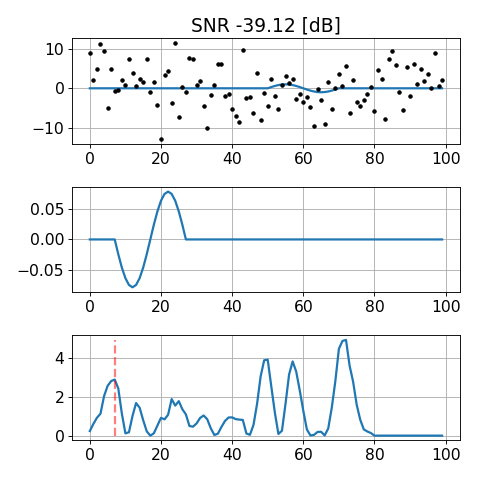

In [147]:
def sine_pulse(n, k0, center):
    x = np.zeros_like(n, dtype=np.float); L = int(1/k0)
    x[center:center+L] = np.sin(2.0*np.pi*k0*(n[center:center+L] - n[center]))
    return x

plt.close('all'); fig, ax = plt.subplots(3, figsize=(6, 6))
np.random.seed(0); n = np.arange(0, 100, step=1)
x_clean = sine_pulse(n, k0=0.05, center=50) 
ax[0].plot(n, x_clean)
s = 0.05; 
x = x_clean + s*np.random.randn(len(n))
ax[0].plot(n, x, 'k.'); ylims = ax[0].get_ylim()
ax[0].set_title("SNR %0.2f [dB]" %(10*np.log(0.5/s**2)))
# System:
h = np.sin(2.0*np.pi*0.05*n[:int(len(n)/5)] + np.pi); h = h/np.sum(np.absolute(h))
# Acumulator
y = np.zeros_like(n, dtype=np.float)
def update(m):
    c = np.zeros_like(n, dtype=np.float); c[m:m+len(h)] = h
    ax[1].cla(); ax[1].plot(c); 
    y[m] = np.sum(h*x[m:m+len(h)])
    ax[2].cla(); ax[2].plot(n, y**2);  #ax[2].set_ylim(ylims)
    ax[2].plot([m, m], [np.amin(y**2), np.amax(y**2)], 'r--', alpha=0.5)
#interact(update, L=SelectionSlider_nice(options=[1, 2, 3, 4, 5, 10, 15, 20]));
anim = animation.FuncAnimation(fig, update, frames=100-len(h), interval=40, blit=True)

***

# Sistema invariante al desplazamiento

***

Un sistema es invariante al desplazamiento  (*shift-invariant*) de su entrada si 

$$
f(x[n-m]) = y[n-m] 
$$

Es decir que 
- Aplicar un retardo en la entrada provoca un retardo equivalente en la salida
    - Un *blip* en la entrada produce un *blop* en la salida sin importar **cuando** ocurre el blip
- Las características del sistema no cambian con $n$
- Si $n$ representa el tiempo decimos que el sistema es **invariante en el tiempo**


***
Un sistema FIR es invariante al desplazamiento si los valores de $h$ son constantes para todo $n$

$$
h[n] = C \quad \forall n
$$

***

<IPython.core.display.Javascript object>


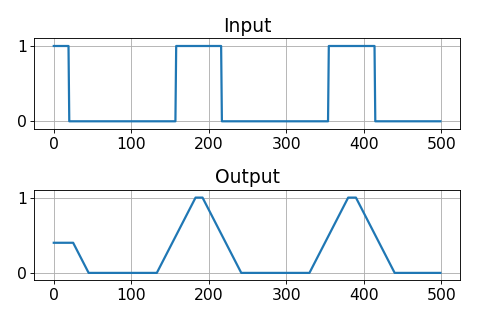

In [150]:
plt.close('all'); fig, ax = plt.subplots(2, figsize=(6, 4))
n = np.arange(0, 500)
l0 = ax[0].plot(n, np.zeros_like(n)); 
ax[0].set_ylim([-0.1, 1.1]); ax[0].set_title('Input')
l1 = ax[1].plot(n, np.zeros_like(n));


def update(m):
    x = 0.5 + 0.5*scipy.signal.square((n-m)/(2.*np.pi*5), duty=0.3)      
    ax[1].set_ylim([-0.1, 1.1]); ax[1].set_title('Output')
    L = 50; h = np.ones(shape=(L, ))
    # h = 1.+ np.cos(2.0*np.pi*2.*(n-m)/len(n))
    h = h/np.sum(np.absolute(h))
    l0[0].set_ydata(x); l1[0].set_ydata(scipy.signal.convolve(x, h, mode='same'))

anim = animation.FuncAnimation(fig, update, frames=500, interval=40, blit=True)

***

# Respuesta al impulso de un sistema

***

Sea el impulso unitario o delta de Kronecker
$$
\delta[n-m] = \begin{cases} 1 & n=m \\ 0 & n \neq m \end{cases}
$$

La **respuesta al impulso de un sistema discreto** es la salida obtenida cuando la entrada es un impulso unitario

***

Para un sistema FIR arbitrario tenemos

$$
y[n]|_{x=\delta} = (h * \delta)[n] = \sum_{j=0}^L h[j] \delta[n-j] = \begin{cases} h[n] & n \in [0, L] \\ 0 & \text{en otro caso} \end{cases} \\
$$

es decir que la respuesta al impulso:
-  tiene **una duración finita y luego decae a zero**
-  recupera los coeficientes $h[j]$ del sistema

En un sistema causal se tiene que $h[n] = 0 \quad \forall n < 0$

Llamamos **soporte** del sistema a todos aquellos valores de $n$ tal que  $h[n] \neq 0$

***

**Ejemplo:** Para 
$$
y[n] = x[n] + A x[n-m]
$$
la respuesta al impulso es: 
$$
y[n] = \delta[n] + A \delta[n-m] = \begin{cases} 1 & n=0\\ A& n=m \\ 0 & \text{en otro caso} \end{cases}
$$

***

# Respuesta en frecuencia de un sistema

***

Es la salida que se obtiene al aplicar una entrada sinusoidal  

$$
x[n]=e^{j \frac{2\pi}{N} kn }
$$

a distintas frecuencias 

**Resultado importante:** La respuesta en frecuencia es la DFT de la respuesta al impulso 

$$
H[k] = \sum_{n=0}^{N-1} h[n] e^{-j \frac{2\pi}{N} kn }
$$

***

**Ejemplo:** Para 

$$
y[n] = x[n] + A x[n-m]
$$

su respuesta en frecuencia es:

$$
y[n] = e^{j \frac{2\pi}{N} kn } + A e^{j \frac{2\pi}{N} k(n-m) }
$$

y $h[n] = \delta[n] + A \delta[n-m]$ cuya DFT es 

$$
H[k] = 1 +  A e^{-j \frac{2\pi}{N} km }
$$

y

$$
|H[k]| = 2 + 2 A \cos \left(\frac{2\pi}{N} km \right) 
$$

In [ ]:
plt.close('all'); plt.figure()
h = np.ones(shape=(11)); 
#plt.plot((fftpack.fft(h, n=len(h))));
plt.plot(2+ 2*np.cos(2*np.pi*np.arange(0, 1000)*5/1000))

***
[Volver al índice](#index)
<a id="section2"></a>

# Sistema LTI 
***

Los sistemas LTI (*linear time-invariant*) cumplen 

- linealidad: homogeneo y aditivo
- invarianza al desplazamiento de la entrada

y se expresan como

$$
y[n] = (h * x)[n] = \sum_j h[j] x[n-j]
$$
- h es la respuesta al impulso
- h guarda los coeficientes del sistema

***
Por propiedad de la DFT sabemos que un sistema LTI cumple

$$
\begin{align}
\text{DFT}_N [y[n]] & = \text{DFT}_N [(h * x)[n]] \nonumber \\
\text{DFT}_N [y[n]] & = \text{DFT}_N [h[n]]  \text{DFT}_N [x[n]] \nonumber \\
Y[k] &= H[k] X[k] , \nonumber
\end{align}
$$

donde convertimos la convolución temporal en una multiplicación frecuencial


- Llamamos a $H[k]$ la **respuesta en frecuencia del sistema** 
- La respuesta en frecuencia es la transformada de Fourier de la respuesta al impulso

***

Los sistemas LTI tienen intepretación directa en el dominio del frecuencia

***

***

# Filtros digitales
***

Un **filtro** es un sistema cuyo objetivo es reducir o resaltar un cierto aspecto de una señal

Por ejemplo

- Disminuir el nivel de ruido
- Separar señales mezcladas
- Ecualizar
- Restaurar (eliminar desenfoque o artefactos de grabación)

Llamamos filtro digital a los filtros aplicados a señales digitales

Hablamos de "señal filtrada" para referirnos a la salida del filtro

A continuación estudiaremos filtros LTI, más adelante extenderemos a filtros adaptivos (no-TI) y filtros no-lineales (no-L)

***

El **filtro LTI** se puede estudiar en frecuencia usando 

$$
Y[k] = H[k] X[k] ,
$$

donde $H[k]$ es la DFT del filtro (respuesta en frecuencia)

- El **filtro LTI** actua como una máscara que modifica el espectro de la entrada
- Solo puede acentuar, atenuar o remover ciertas frecuencias pero **nunca crear nuevas frecuencias**

Consideremos los siguienes filtros (máscaras) ideales

<img src="img/ideal_filters.gif">

***

## Diseño de un filtro FIR 


Recordemos, un filtro FIR 

$$
\begin{align}
y[n] &= h[0] x[n] + h[1] x[n-1] + h[2] x[n-2] + \ldots + h[L] x[n-L] \nonumber \\
&= \sum_{j=0}^{L} h[j] x[n-j] \nonumber \\
&= (h* x)[n] \nonumber 
\end{align}
$$

está definido por su orden (L) y sus coeficientes $h[j], j=0,\ldots, L$
***
Diseñar un filtro consisten en encontrar L y los valores de los coeficientes
***
Podemos diseñar un filtro FIR siguiendo estos pasos

1. Especificar una respuesta en frecuencia ideal $H_d[k]$
1. Usar la transformada de Fourier inversa para obtener la respuesta al impulso ideal $h_d[n]$
1. Truncar la respuesta al impulso ideal usando una ventana tal que $h[n] = h_d[n] w[n]$
1. $h[n]$ nos da los coeficientes del filtro FIR y w[n] nos da el largo del filtro

La ventana $w[n]$ puede ser cualquiera de las funciones vistas en la unidad anterior, por ejemplo una ventana rectangular

$$
w[n] = \begin{cases} 1 & n \leq L \\ 0 & n > L \end{cases}
$$

o la ventana de Hann

$$
w[n] = 0.5 - 0.5 \cos \left( \frac{2\pi n}{L-1} \right)
$$



***

### Ejemplo: Filtro pasa bajo (LPF)

Un filtro pasa bajo es aquel que sólo deja pasar las **bajas** frecuencias

Sus usos son:
- Recuperar una tendencia o comportamiento lento en la señal
- Eliminar el ruido aditivo

Diseñemos un filtro que elimine todas las frecuencias mayores a $f_c$ [Hz] de una señal $x[n]$ muestreada con frecuencia $F_s$. 

1. Propongamos la siguiente respuesta en frecuencia ideal que solo deja pasar las frecuencias menores a $f_c$
$$
\begin{align}
H_d(\omega) &= \begin{cases} K & |f| < f_c\\ 0 & |f| > f_c \end{cases} \nonumber \\
&= K \text{rect}(f/f_c) \nonumber 
\end{align}
$$

1. Obtenemos su transformada de Fourier inversa
$$
\begin{align}
h_d(t) &= K \int_{-f_c}^{f_c} e^{j 2 \pi f t} df \nonumber \\
& = \frac{2j K f_c}{2 j \pi f_c t} \sin(2 \pi f_c t) = 2 K f_c \text{sinc}(2 \pi f_c t) \nonumber 
\end{align}
$$
que es una función infinitamente larga

1. La versión discreta sería
$$
h_d[n] = 2 K f_c\text{sinc}(2 \pi f_c n/ F_s) 
$$

1. Para obtener una respuesta al impulso finita multiplicamos por una ventana de largo finito

$$
h[n] = 2 K f_c \text{sinc}(2 \pi f_c n /F_s) \text{rect}(n/(L+1))
$$

que implica esto en la respuesta en frecuencia real?


<IPython.core.display.Javascript object>


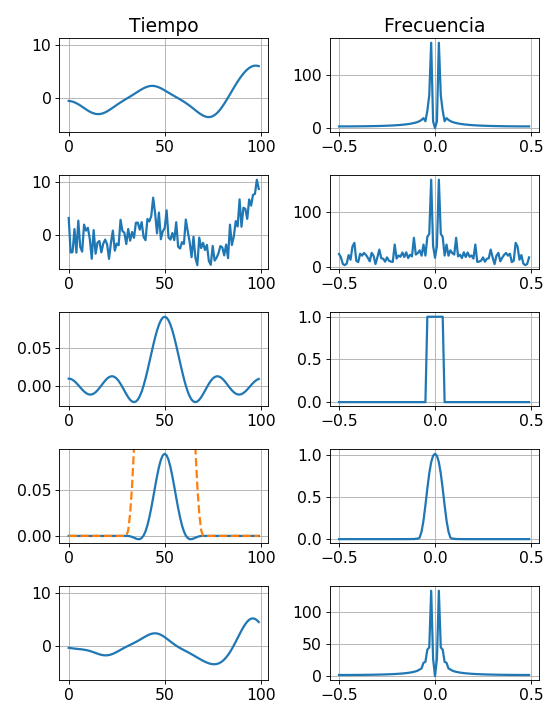

interactive(children=(FloatSlider(value=0.1, continuous_update=False, description='fc', layout=Layout(height='…

In [6]:
plt.close('all'); fig, ax = plt.subplots(5, 2, figsize=(7, 9))
n = np.arange(0, 100, step=1); 
f = fftpack.fftshift(fftpack.fftfreq(n=len(n), d=1))
np.random.seed(0); C = 5*np.exp(-0.5*(n[:, np.newaxis] - n[:, np.newaxis].T)**2/10**2)
x_clean = np.random.multivariate_normal(np.zeros_like(n), C)
x_clean -= np.mean(x_clean)
x = x_clean + 2*np.random.randn(len(n))
def update(fc, L, window='rect'):
    [axx.cla() for axx in ax.ravel()]
    # Señal limpia
    ax[0, 0].plot(n, x_clean); 
    ax[0, 1].plot(f, fftpack.fftshift(np.absolute(fftpack.fft(x_clean))))
    ax[0, 0].set_title("Tiempo"); ax[0, 1].set_title("Frecuencia")    
    # Señal contaminada
    ax[1, 0].plot(n, x); ylims = ax[1, 0].get_ylim(); ax[0, 0].set_ylim(ylims)
    X = fftpack.fft(x); 
    ax[1, 1].plot(f, fftpack.fftshift(np.absolute(X)))
    # Filtro ideal
    kc = int(len(n)*fc)
    Hd = np.zeros_like(n, dtype=np.float); Hd[:kc] = 1.; Hd[len(Hd)-kc+1:] = 1.
    ax[2, 1].plot(f, fftpack.fftshift(Hd))
    hd = np.real(fftpack.ifftshift(fftpack.ifft(Hd)))
    ax[2, 0].plot(n, hd)
    # Filtro real
    w = np.zeros_like(n, dtype=np.float); 
    if window == 'rect':
        w[len(w)//2-L//2:len(w)//2+L//2+1] = 1.;
    elif window == 'hann':
        w[len(w)//2-L//2:len(w)//2+L//2+1] = scipy.signal.hann(L+1)
    h = w*hd; H = fftpack.fft(h); 
    print("NMSE entre H y Hd %0.4f" % (np.mean((np.absolute(H) - Hd)**2)/np.mean(Hd**2)))
    ax[3, 0].plot(n, h);  ylims2 = ax[3, 0].get_ylim(); 
    ax[3, 0].plot(n, w, '--'); ax[3, 0].set_ylim(ylims2)
    ax[3, 1].plot(f, fftpack.fftshift(np.absolute(H)))
    # Señal filtrada
    xf = scipy.signal.convolve(x, h, mode='same')
    ax[4, 0].plot(n, np.real(xf)); 
    ax[4, 1].plot(f, fftpack.fftshift(np.absolute(fftpack.fft(xf)))); ax[4, 0].set_ylim(ylims)
    
interact(update, fc=FloatSlider_nice(min=0.01, max=0.5, step=0.01, value=0.1),
         L=SelectionSlider_nice(options=[4, 6, 10, 20, 40, 60, 80], value=60),
         window=SelectionSlider_nice(options=['rect', 'hann']));

- La respuesta en frecuencia "ideal" $H_d[k]$ es plana y tiene discontinuidades
- La respuesta en frecuencia "real" $H[k]$ busca aproximar a $H_d[k]$
- Observando $H[k]$ notamos que
    - No tiene zonas perfectamente planas (ni es perfectamente zero)
    - No tiene discontinuidades fuertes como el caso ideal
- Esto se debe al recorte que hacemos con la ventana

<img src="img/system-real-filter.png" width="500">

- Podemos usar una ventana suave (Hann) para disminuir los *ripples* al costo de hacer más lenta las transiciones
***
El diseño del filtro está dado entonces por su
- **Función:** Definida por la respuesta en frecuencia ideal $|H_d[k]| \angle H_d[k]$ 
    - Podemos definir la magnitud o el ángulo dependiendo de la aplicación
- **Fidelidad:** El error tolerable entre la respuesta en frecuencia ideal y la real
***

***

### Ejemplo: Filtro pasa alto (HPF)

Un filtro pasa alto es aquel que sólo deja pasar las **altas** frecuencias

Sus usos son:
- Identificar cambios/detalles, es decir comportamientos rápidos en una señal
- Eliminar tendencias

Diseñemos un filtro que elimine todas las frecuencias menores a $f_c$ [Hz] de una señal $x[n]$ muestreada con frecuencia $F_s$. 

1. Propongamos la siguiente respuesta en frecuencia ideal que solo deja pasar las frecuencias **mayores** a $f_c$
$$
H_d(\omega) = \begin{cases} K & |f| \geq f_c\\ 0 & |f| < f_c \end{cases} 
$$

1. Obtenemos su transformada de Fourier inversa
$$
\begin{align}
h_d(t) &= K \int_{-\infty}^{-f_c} e^{j 2 \pi f t} df  + K \int_{f_c}^{\infty} e^{j 2 \pi f t} df\nonumber \\
&= K \int_{-\infty}^{\infty} e^{j 2 \pi f t} df  - K \int_{-f_c}^{f_c} e^{j 2 \pi f t} df\nonumber \\
& = K \delta(t) - 2 K f_c \text{sinc}(2 \pi f_c t) \nonumber 
\end{align}
$$

1. La versión discreta sería
$$
h_d[n] = K (\delta[n] - 2 F_c\text{sinc}(2 \pi f_c n/ F_s) )
$$

1. Finalmente la hacemos finita multiplicando por una ventana de largo finito
$$
h[n] = K (\delta[n] - 2 f_c\text{sinc}(2 \pi f_c n/ F_s) ) \text{rect}(n/(L+1))
$$

***
- Un filtro pasa alto se obtiene de forma trivial **restandole un filtro pasa bajo a un impulso unitario**
- Este "truco" se conoce como  **inversión espectral**


<img src="img/system-hpf.png" width="400">
***


<IPython.core.display.Javascript object>


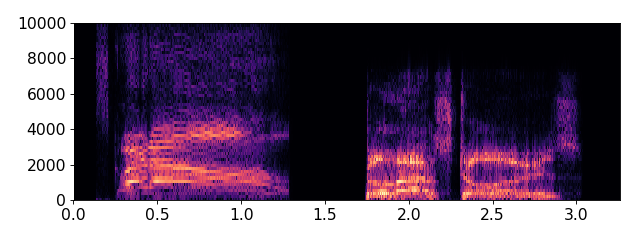

In [7]:
data, sample_rate = sf.read("data/nomekop.ogg")
plt.close('all'); fig, ax = plt.subplots(1, figsize=(8, 3))
freq, ttime, Sxx = scipy.signal.spectrogram(data, fs=sample_rate, window=('tukey', 0.25), 
                                            nperseg=256, noverlap=None, detrend=False,
                                            return_onesided=True, scaling='density', mode='magnitude')
ax.pcolormesh(ttime, freq, 20*np.log10(Sxx+1e-4), cmap=plt.cm.magma); ax.set_ylim([0.0, 1e+4]);
Audio(data, rate=int(sample_rate));

<IPython.core.display.Javascript object>


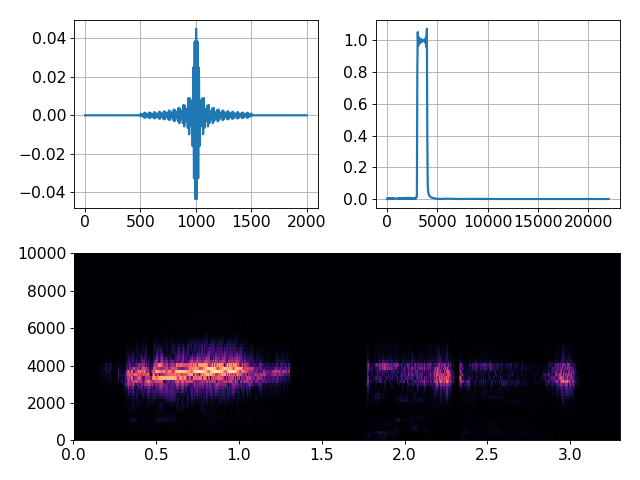

In [132]:
def low_pass_h(L, fc):
    h = np.sinc(2*fc*np.arange(-L//2, L//2)/sample_rate)
    return h/np.sum(h) # ganancia unitaria K = 1/(2fc sum h)

L = 1000+1; fc_lp, fc_hp = 4000, 3000
h_lp = low_pass_h(L, fc_lp)
h_hp = -low_pass_h(L, fc_hp); h_hp[L//2+1] += 1
plt.close('all'); fig = plt.figure(figsize=(8, 6))
ax1 = plt.subplot2grid((2, 2 ), (0, 0))
ax2 = plt.subplot2grid((2, 2 ), (0, 1))
ax3 = plt.subplot2grid((2, 2 ), (1, 0), colspan=2, rowspan=1)
#h = h_lp
#h = h_hp + h_lp
h = scipy.signal.convolve(h_hp, h_lp)
freq, response = scipy.signal.freqz(h)
ax1.plot(h); ax2.plot(0.5*sample_rate*freq/np.pi, np.abs(response));
data_filt = scipy.signal.convolve(data, h)
freq, ttime, Sxx = scipy.signal.spectrogram(data_filt, fs=sample_rate, window=('tukey', 0.25), 
                                            nperseg=256, noverlap=None, detrend=False,
                                            return_onesided=True, scaling='density', mode='magnitude')
ax3.pcolormesh(ttime, freq, 20*np.log10(Sxx+1e-4), cmap=plt.cm.magma); ax3.set_ylim([0.0, 1e+4]);
Audio(data_filt, rate=int(sample_rate))

***

### Ejemplo: Filtro pasa banda (BPF) y rechaza banda (BRF)

- Como sus nombres lo indicam estos filtros 
    - Dejan pasar una cierta banda de frecuencia (BPF) o
    - Dejan pasar todas las frecuencias excepto una banda determinada (BRF)
- La banda de frecuencia está definida por sus frecuencias de corte mínima y máxima 
- Se pueden construir combinando el filtro pasa bajo y pasa alto

**Filtro pasa banda**: 
Para recuperar solo una cierta banda de frecuencia seguimos:
1. Definir frecuencias de corte $f_{c1} < f_{c2}$
- Construir un filtro pasa bajo con frecuencia de corte $f_{c2}$
- Convolucionar la señal con la respuesta al impulso resultante
- Construir un filtro pasa alto con frecuencia de corte $f_{c1}$
- Convolucionar la señal filtrada con la respuesta al impulso resultante

<img src="img/system-bpf.png" width="400">

**Filtro rechazabanda**: 
Para eliminar una cierta banda de frecuencia seguimos:
1. Definir frecuencias de corte $f_{c1} > f_{c2}$
- Construir un filtro pasa bajo con frecuencia de corte $f_{c2}$
- Construir un filtro pasa alto con frecuencia de corte $f_{c1}$
- Sumar ambos las respuestas al impulso de ambos filtros
- Convolucionar la señal con la respuesta al impulso resultante

<img src="img/system-rbf.png" width="400">

***

### Filtro FIR con respuesta en frecuencia arbitraria

Consideremos un filtro FIR 
- De orden $L$ (par) con $L+1$ coeficientes 
- Centrado en el origen (cero fase)
- Con respuesta al impulso simétrica: $h_{n} = h_{-n}$

Podemos escribir su respuesta en frecuencia como 

$$
H[k] = \sum_{n=-L/2}^{L/2} h[n] e^{-j \frac{2\pi}{N} k n} = h[0] + \sum_{n=1}^{L/2} \cos \left(\frac{2\pi}{N} k n\right)
$$
que para $k=0, \ldots, N-1$ en forma matricial es

$$ 
\begin{align} 
\begin{pmatrix} H[0] \\ H[1] \\ H[2] \\ \vdots \\ H[N-1] \\ \end{pmatrix} 
&= 
\begin{pmatrix} 
1 & 1 & 1 & \cdots & 1 \\ 
1 & \cos \left(\frac{2\pi}{N} \right) & \cos \left(\frac{2\pi}{N} 2\right) & \cdots & \cos \left(\frac{2\pi}{N} L/2\right) \\ 
1 & \cos \left(\frac{2\pi}{N} 2 \right) & \cos \left(\frac{2\pi}{N} 4 \right) & \cdots & \cos \left(\frac{2\pi}{N} 2 L/2\right) \\ 
\vdots & \dots & \dots & \ddots & \vdots \\ 
1 & \cos \left(\frac{2\pi}{N} (N-1)\right) & \cos \left(\frac{2\pi}{N} (N-1) 2\right) & \cdots & \cos \left(\frac{2\pi}{N} (N-1) L/2\right) \\ 
\end{pmatrix} 
\begin{pmatrix} h[0] \\ h[1] \\ h[2] \\ \vdots \\ h[L/2] \\ \end{pmatrix} \nonumber \\
H &= A h, 
\end{align} 
$$
donde $A \in \mathbb{R}^{NxL/2}$

Si especificamos $H$ podemos despejar $h$ pero no podemos invertir A ya que no es cuadrada.
***
Una alternativa es buscar $\hat h \approx h$ que minimice el error cuadrático medio

$$
\min_h \| H - Ah\|^2,
$$
derivando e igualando a cero obtenemos el sistema de **ecuaciones normales**
$$
\begin{align}
A^T (H - Ah) &= 0 \nonumber \\
\hat h &= (A^T A)^{-1} A^T H = A^{\dagger} H,
\end{align}
$$
donde 
- $A^{\dagger}$ se conoce como la pseudo-inversa de A
- $\hat h$ se conoce como el **estimador de mínimos cuadrados** de h
***

<IPython.core.display.Javascript object>


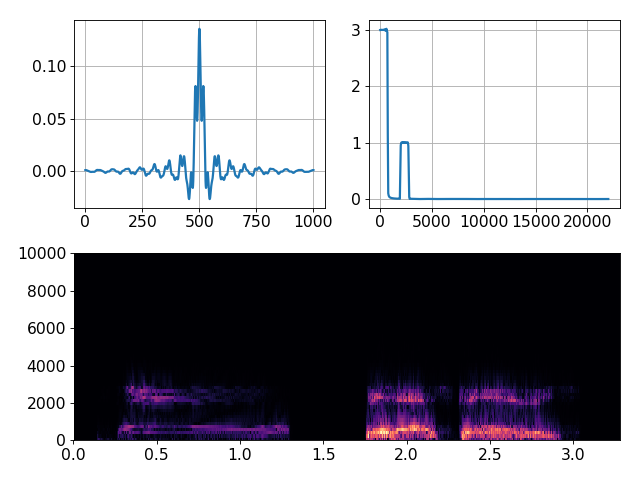

In [143]:
# Estimador de minimos cuadrados para filtro FIR usando scipy.signal
h = scipy.signal.firls(numtaps=1000+1, 
                       bands=(0., 700, 750, 1900, 2000, 2700, 2800, sample_rate//2), 
                       desired=(3., 3., 0., 0., 1., 1., 0., 0.), fs=sample_rate)
plt.close('all'); fig = plt.figure(figsize=(8, 6))
ax1 = plt.subplot2grid((2, 2 ), (0, 0))
ax2 = plt.subplot2grid((2, 2 ), (0, 1))
ax3 = plt.subplot2grid((2, 2 ), (1, 0), colspan=2, rowspan=1)
freq, response = scipy.signal.freqz(h)
ax1.plot(h); ax2.plot(0.5*sample_rate*freq/np.pi, np.abs(response));
data_filt = scipy.signal.convolve(data, h/np.sum(np.absolute(h)))
freq, ttime, Sxx = scipy.signal.spectrogram(data_filt, fs=sample_rate, window=('tukey', 0.25), 
                                            nperseg=256, noverlap=None, detrend=False,
                                            return_onesided=True, scaling='density', mode='magnitude')
ax3.pcolormesh(ttime, freq, 20*np.log10(Sxx+1e-4), cmap=plt.cm.magma); ax3.set_ylim([0.0, 1e+4]);
#ax[2].plot(np.sum(Sxx, axis=0))
Audio(data_filt, rate=int(sample_rate))

Como vimos antes un filtro FIR de buena calidad puede requerir una gran cantidad de coeficientes

Es posible implementar filtros más eficientes usando recursividad

***

# Sistema IIR (infinite impulse response)


Generalizando el sistema FIR para incluir versiones pasadas de la salida y asumiendo $a[0] = 1$ llegamos a 

$$
\begin{align}
y[n] &= b[0] x[n] + b[1] x[n-1] + b[2] x[n-2] + \ldots + b[L] x[n-L]  \nonumber \\
& - a[1] y[n-1] - a[2] y[n-2] - \ldots - a[M] y[n-M] \nonumber \\
&= \sum_{j=0}^{L} b[j] x[n-j] - \sum_{j=1}^{M} a[j] y[n-j]  \nonumber  \\
\sum_{j=0}^{M} a[j] y[n-j] &= \sum_{j=0}^{L} b[j] x[n-j] \nonumber \\
(a * y)[n] &= (b * x)[n], \nonumber
\end{align}
$$

es decir dos convoluciones discretas que definen una **ecuación de diferencias**

Este tipo de sistema se conoce como 
- sistema IIR (infinite impulse response)
- sistema *auto-regresive moving average* (ARMA)
    - autoregresivo de orden M: incluye valores pasados de la salida
    - media movil de orden L+1: pondera el valor presente y pasados de la entrada

***

Aplicando la transformada de Fourier convertimos las convoluciones en multiplicaciones y encontramos su respuesta en frecuencia como

$$
\begin{align}
\mathbb{FT}[(a * y)[n]] &= \mathbb{FT}[(b * x)[n]] \nonumber \\
A[k] Y[k] &= B[k] X[k] \nonumber \\
Y[k] &= \frac{B[k]}{A[k]} X[k] \nonumber \\
&= H[k] X[k], \nonumber
\end{align}
$$
siempre que $A[k] \neq 0$

***
Cuando se recupera el sistema FIR?
- Si $a[j] = 0$ para $j=[1, \ldots, M]$ o si
- Si $A[k] = 1$ para todo $k$ 


### Ejemplo:

Consideremos el sistema IIR sencillo

$$
y[n] = x[n] + A y[n-1]
$$

¿Cuántos coeficientes tiene este sistema?
R: $a[0] = 1$, $a[1] = A$ y $b[0] = 1$, es decir MA de orden 1 y AR de orden 1

¿Cúal es su respuesta al impulso?

$$
\begin{matrix}
n & \delta[n] & y[n] \\
-2 & 0 & 0 \\
-1 & 0 & 0 \\
0 & 1 & 1 \\
1 & 0 & A \\
2 & 0 & A^2 \\
3 & 0 & A^3\\
4 & 0 & A^4\\
\end{matrix}
$$

¿Qué pasa si $A \geq 1$?

<IPython.core.display.Javascript object>


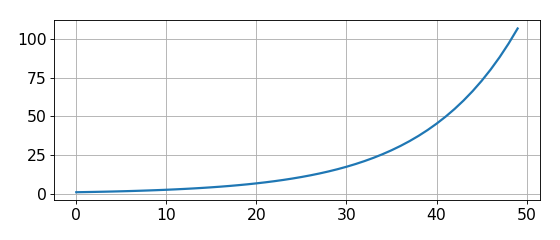

interactive(children=(FloatSlider(value=0.1, continuous_update=False, description='A', layout=Layout(height='2…

In [197]:
plt.close('all'); fig, ax = plt.subplots(1, figsize=(7, 3))

def update(A):
    t, y = scipy.signal.dimpulse(([1, 0], [1, -A], 1), x0=0, n=50)
    ax.cla(); ax.plot(t, y[0]);
interact(update, A=FloatSlider_nice(min=0.1, max=1.1, step=0.01));

- La respuesta al impulso puede tender a infinito!
- A diferencia de un sistema FIR el sistema IIR puede tener configuraciones
    - Estable: $h$ tiende a cero
    - Condicionalmente estable: $h$ oscila a una taza constante
    - Inestable: $h$ crece infinitamente

Consideremos el sistema anterior y asumamos que
- $y[n] = 0$ si $n<0$
- $A<1$

desenrollando tenemos que 
$$
\begin{align}
y[0] &= x[0] \nonumber \\
y[1] &= x[1] + A x[0] \nonumber \\
y[2] &= x[2] + A x[1] + A^2 x[0] \nonumber \\
y[3] &= x[3] + A x[2] + A^2 x[1] + A^3 x[0] \nonumber \\
y[4] &= x[4] + A x[3] + A^2 x[2] + A^3 x[1]  + A^4 x[0] \nonumber \\
y[5] &= \ldots \nonumber 
\end{align}
$$

Con un sistema IIR de 3 coeficientes podemos representar un sistema FIR considerablemente más grande

Por ejemplo si escogemos $A$ tal que $A^{20 }\approx 0$ entonces aproximamos un sistema FIR de orden 20

In [198]:
CUAL ES LA RESPUESTA EN FRECUENCIA DE ESTE SISTEMA!!!!!!!!!

SyntaxError: invalid syntax (<ipython-input-198-445f170c32c3>, line 1)

***

# Generalizando la DFT: Transformada Z

***

Sea una señal muestrada como una secuencia finita $x[n]$, $n=0, \ldots, N-1$

Su **transformada Z** es 

$$
X[z] = \sum_{n=0}^{N-1} x[n] z^{-n},
$$

donde $z$ es un número complejo. Por ejemplo si $z=r e^{j \frac{2\pi}{N} k}$ entonces

$$
X[z] = \sum_{n=0}^{N-1} x[n]r^{-n} e^{-j \frac{2\pi}{N} nk},
$$

es decir que 
- la transformada Z es la DFT de la secuencia $x[n]r^{-n}$ 
- la transformada Z puede usarse con $\sum_n |x[n]r^{-n}| \leq \infty$
- si $r=1$ entonces $z= e^{j \frac{2\pi}{N} k}$, y la transformada Z es equivalente a la DFT
- la DFT es un caso particular de la transformada Z

***

### Propiedades 

Dos propiedades relevantes para nuestros propósitos son
- Linealidad:  $Z\{a x[n] +  b y[n]\} = a X[z] + b Y[z]$
- Convolución: $Z\{x[n] * y[n]\}  =  X[z] Y[z]$
- Traslación: $X[z-m] = X[z]z^{-m}$ 



https://www.quora.com/Why-do-we-use-Z-Transform

***

# Función de transferencia de un sistema


El sistema IIR general se define con la ecuación de diferencias

$$
\sum_{j=0}^{M} a[j] y[n-j] = \sum_{j=0}^{L} b[j] x[n-j],
$$

Aplicando transformada Z a ambos lados tenemos y despejando

$$
\begin{align}
\sum_{j=0}^{M} a[j] Y[z] z^{-j} &= \sum_{j=0}^{L} b[j] X[z] z^{-j} \nonumber \\
Y[z] \sum_{j=0}^{M} a[j]  z^{-j} &= X[z] \sum_{j=0}^{L} b[j]  z^{-j}, \nonumber \\
H[z] = \frac{Y[z]}{X[z]} &=  \frac{\sum_{j=0}^{L} b[j] z^{-j} }{ \sum_{j=0}^{M} a[j] z^{-j} } , \nonumber 
\end{align}
$$
donde $H[z]$ se conoce como **función de transferencia** del sistema y suele expresarse como

$$
H[z] = \frac{\sum_{j=0}^{L} b[j] z^{-j} }{ \sum_{j=0}^{M} a[j] z^{-j} } = C \frac{ \prod_{j=1}^L (1-\beta_j z^{-1})}{ \prod_{j=1}^M (1-\alpha_j z^{-1})},
$$

donde $\{\alpha_j\}$ son los **polos** del sistema y $\{\beta_j\}$ son los **ceros** del sistema 

***

**Ejemplo:** El sistema IIR que vimos anteriormente

$$
y[n] = x[n] + A y[n-1]
$$

Aplicando transformada Z y obtenemos la siguiente función de transferencia

$$
\begin{align}
Y[z] &= X[z] + A Y[z] z^{-1} \nonumber \\
H[z] = \frac{Y[z]}{X[z]} &= \frac{1}{1 - Az^{-1}} = \frac{(z - 0)}{(z - A)} \nonumber
\end{align}
$$

que tiene un polo en $A$ y un cero en $0$





https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.dlti.html#scipy.signal.dlti

In [199]:
relación con la respuesta en frecuencia

SyntaxError: invalid syntax (<ipython-input-199-459d2f7c121d>, line 1)

### Filtro pasa bajo

https://www.dsprelated.com/showarticle/164.php

first order second order biquad

### Filtro pasa todo (all pass filter)

aplicacion definiendo el angulo

https://www.dsprelated.com/freebooks/filters/Allpass_Filters.html
http://www.dspguide.com/ch20/2.htm
http://www.dspguide.com/ch22.htm
http://www.dspguide.com/ch33.htm
https://ccrma.stanford.edu/~nfram/220c/tvfilts.html
https://sound.eti.pg.gda.pl/student/eim/synteza/adamx/eindex.html
http://www.ee.ic.ac.uk/hp/staff/dmb/courses/DSPDF/00500_Filters.pdf

ecuaciones de diferencia

ejemplos de sistema IIR

## Flanger

Generalizando la DFT: Transformada Z

Transformada Z de sistemas LTI

Diagrama de polos y ceros

Respuesta en frecuencia, respuesta al impulso y función de transferencia

## Filtro Butterworth

https://www.dsprelated.com/showarticle/1119.php



https://ipython-books.github.io/102-applying-a-linear-filter-to-a-digital-signal/

http://www.dspguide.com/ch14/1.htm

http://www.dspguide.com/ch22.htm

http://www.dspguide.com/ch33.htm

In [ ]:
plt.close('all'); fig, ax = plt.subplots(2, figsize=(6, 4))
n = np.arange(0, 400, step=1)
x = np.sin(2.0*np.pi*20*n/len(n)) + 0.25*np.random.randn(len(n))
f = fftpack.fftshift(fftpack.fftfreq(d=1, n=len(n)))
def update(L):
    y = np.convolve(x, np.ones(shape=(L,))/L, mode='same')
    ax[0].cla(); ax[0].plot(n, x, 'k.', n, y, 'r-'); 
    X = fftpack.fftshift(fftpack.fft(y*scipy.signal.hamming(len(n))))
    ax[1].cla(); ax[1].plot(f, 2*np.absolute(X)/len(n)); 
interact(update, L=SelectionSlider_nice(options=[1, 2, 3, 4, 5, 10, 15, 20]));


    Modelado de señales
    Algoritmo Least Mean Squares (LMS)
    Cancelación de ruido y eco, Ecualización adaptiva
    Algoritmo Recursive Least Squares (RLS)
    Filtro de Kalman
    
    https://scipy-cookbook.readthedocs.io/items/KalmanFiltering.html
    
    
    Algoritmos KLMS y KRLS


***

# Contenidos de la unidad

***

1. Detección y comparación de señales
1. Espectro de potencia y Teorema de Wiener-Khinchin
1. Detección de señales con Match filter
1. Limpieza de señales con filtro de Wiener

***
[Volver al índice](#index)

<a id="section1"></a>

# Detección y comparación de señales en el tiempo

***



https://ccrma.stanford.edu/~jos/filters/filters.html